In [2]:
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils as ut
from scipy.stats import pearsonr, spearmanr
import bct
from matplotlib import font_manager
from visual_config import *
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D
for font in font_manager.findSystemFonts("figures/Atkinson_Typeface/"):
    font_manager.fontManager.addfont(font)

set_visual_style()

In [3]:
sagittal = (0, 180)
axial = (90, 180)
coronal = (0, 90)

monochrome = sns.blend_palette([HALF_BLACK, GRAY], as_cmap=True)
scatter_kw_network = dict(alpha=1, linewidths=0, edgecolors=HALF_BLACK)

In [4]:
consensus_mat = scipy.io.loadmat(
    "Consensus_Connectomes.mat",
    simplify_cells=True,
    squeeze_me=True,
    chars_as_strings=True,
)
connectivity = ut.spectral_normalization(
    1, consensus_mat["LauConsensus"]["Matrices"][2][0]
)
labels = consensus_mat["LauConsensus"]["Matrices"][2][4][:, 0]
lognorm_sc = ut.log_minmax_normalize(connectivity)

/home/kayson/ownCloud/communication-and-causation/utils.py:288: RuntimeWarning: divide by zero encountered in log
  return np.nan_to_num(np.log(adjacency_matrix), neginf=0, posinf=0)


In [5]:
N_TRIALS = 10
all_trials = np.zeros((len(connectivity), len(connectivity), N_TRIALS))

for trial in range(N_TRIALS):
    temp = (
        pd.read_pickle(
            f"results/nonlinear_weighted/causal_modes_nl_w_{len(connectivity)}_{trial}.pickle"
        )
        .groupby(level=0)
        .var()
        .fillna(0)
    )
    all_trials[:, :, trial] = temp
averaged_nl_ci = all_trials.mean(axis=2)
lognorm_nl_ci = ut.log_minmax_normalize(averaged_nl_ci)

/home/kayson/ownCloud/communication-and-causation/utils.py:288: RuntimeWarning: divide by zero encountered in log
  return np.nan_to_num(np.log(adjacency_matrix), neginf=0, posinf=0)


In [6]:
all_trials = np.zeros((len(connectivity), len(connectivity), N_TRIALS))

for trial in range(N_TRIALS):
    temp = (
        pd.read_pickle(
            f"results/linear_weighted/causal_modes_l_w_{len(connectivity)}_{trial}.pickle"
        )
        .groupby(level=0)
        .var()
        .fillna(0)
    )
    all_trials[:, :, trial] = temp
averaged_l_ci = all_trials.mean(axis=2)
lognorm_l_ci = ut.log_minmax_normalize(averaged_l_ci)
np.fill_diagonal(lognorm_l_ci, 0.0)

/home/kayson/ownCloud/communication-and-causation/utils.py:288: RuntimeWarning: divide by zero encountered in log
  return np.nan_to_num(np.log(adjacency_matrix), neginf=0, posinf=0)


In [7]:
macaque_sc = np.loadtxt("macaqueSC")
macaque_sc_lognorm = ut.log_minmax_normalize(macaque_sc)
all_trials = np.zeros((len(macaque_sc), len(macaque_sc), N_TRIALS))

for trial in range(N_TRIALS):
    temp = (
        pd.read_pickle(
            f"results/linear_weighted/macaqueSC_causal_modes_l_w_{len(macaque_sc)}_{trial}.pickle"
        )
        .groupby(level=0)
        .var()
        .fillna(0)
    )
    all_trials[:, :, trial] = temp
macaque_averaged_l_ci = all_trials.mean(axis=2)
macaque_lognorm_l_ci = ut.log_minmax_normalize(macaque_averaged_l_ci)
macaque_direct_influence = pd.DataFrame(macaque_lognorm_l_ci).where(macaque_sc != 0)

/home/kayson/ownCloud/communication-and-causation/utils.py:288: RuntimeWarning: divide by zero encountered in log
  return np.nan_to_num(np.log(adjacency_matrix), neginf=0, posinf=0)


In [8]:
from netneurotools import datasets

mouse_sc = datasets.fetch_connectome("mouse")["conn"]
mouse_sc_lognorm = ut.log_minmax_normalize(ut.minmax_normalize(mouse_sc))

all_trials = np.zeros((len(mouse_sc), len(mouse_sc), N_TRIALS))
for trial in range(N_TRIALS):
    temp = (
        pd.read_pickle(
            f"results/linear_weighted/netneuro_mouse_causal_modes_l_w_{len(mouse_sc)}_{trial}.pickle"
        )
        .groupby(level=0)
        .var()
        .fillna(0)
    )
    all_trials[:, :, trial] = temp
mouse_averaged_l_ci = all_trials.mean(axis=2)
mouse_lognorm_l_ci = ut.log_minmax_normalize(mouse_averaged_l_ci)
mouse_direct_influence = pd.DataFrame(mouse_lognorm_l_ci).where(mouse_sc != 0)

/home/kayson/ownCloud/communication-and-causation/utils.py:288: RuntimeWarning: divide by zero encountered in log
  return np.nan_to_num(np.log(adjacency_matrix), neginf=0, posinf=0)
/home/kayson/ownCloud/communication-and-causation/utils.py:288: RuntimeWarning: divide by zero encountered in log
  return np.nan_to_num(np.log(adjacency_matrix), neginf=0, posinf=0)


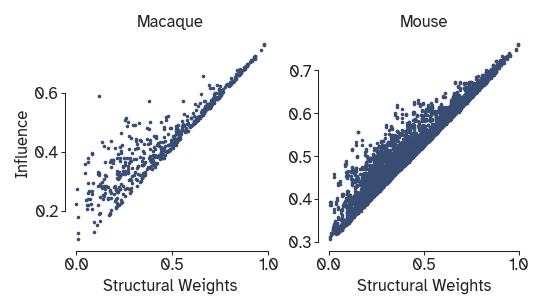

In [9]:
fig, axes = plt.subplot_mosaic([["A", "B"]], figsize=SMALL, dpi=150)

sns.scatterplot(
    x=macaque_sc_lognorm.flatten()[macaque_sc.flatten() != 0],
    y=macaque_direct_influence.values.flatten()[macaque_sc.flatten() != 0],
    s=3,
    linewidth=0,
    ax=axes["A"],
    rasterized=True,
    color=NIGHT_BLUE,
)

sns.scatterplot(
    x=mouse_sc_lognorm.flatten()[mouse_sc_lognorm.flatten() != 0.0],
    y=mouse_direct_influence.values.flatten()[mouse_sc_lognorm.flatten() != 0.0],
    s=3,
    linewidth=0,
    ax=axes["B"],
    rasterized=True,
    color=NIGHT_BLUE,
)
axes["A"].set_ylabel("Influence", fontsize=8)
axes["A"].set_xlabel("Structural Weights", fontsize=8)

# axes["B"].set_yticklabels([])
axes["B"].set_xlabel("Structural Weights", fontsize=8)

axes["A"].set_title("Macaque", fontsize=8)
axes["B"].set_title("Mouse", fontsize=8)
sns.despine(fig=fig, offset=1, trim=True)
fig.tight_layout(pad=0.5)
plt.savefig(f"figures/scatter_sc_ci_mouse_macaque.pdf", dpi=600, bbox_inches="tight")

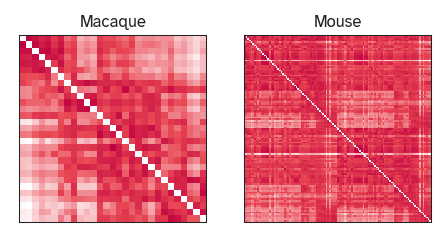

In [10]:
fig, axes = plt.subplot_mosaic([["A", "B"]], figsize=SMALL, dpi=150)

sns.heatmap(
    macaque_lognorm_l_ci,
    cmap=white_red_mono,
    square=True,
    xticklabels=False,
    yticklabels=False,
    cbar=False,
    ax=axes["A"],
)
sns.heatmap(
    mouse_lognorm_l_ci,
    cmap=white_red_mono,
    square=True,
    xticklabels=False,
    yticklabels=False,
    cbar=False,
    ax=axes["B"],
)
axes["A"].set_title("Macaque", fontsize=8)
axes["B"].set_title("Mouse", fontsize=8)

sns.despine(fig=fig, top=False, right=False, left=False, bottom=False)
plt.savefig(f"figures/heatmap_ci_mouse_macaque.pdf", dpi=600, bbox_inches="tight")

In [11]:
mouse_indirect_influence = pd.DataFrame(mouse_lognorm_l_ci).where(mouse_sc == 0)
mouse_influence_gradient = pd.DataFrame(
    ut.minmax_normalize(ut.threshold(5, mouse_indirect_influence).sum(0).values)
)

In [12]:
linear_regressor = LinearRegression()
linear_regressor.fit(
    mouse_sc_lognorm.flatten()[mouse_sc_lognorm.flatten() != 0].reshape(-1, 1),
    mouse_direct_influence.values.flatten()[mouse_sc_lognorm.flatten() != 0],
)
Y_pred = linear_regressor.predict(
    mouse_sc_lognorm.flatten()[mouse_sc_lognorm.flatten() != 0].reshape(-1, 1)
)
residuals = (
    mouse_direct_influence.values.flatten()[mouse_sc_lognorm.flatten() != 0] - Y_pred
)

residual_matrix = mouse_sc_lognorm.copy()
residual_matrix[residual_matrix != 0] = residuals


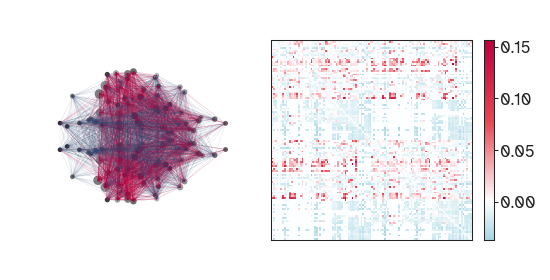

In [13]:
coordinates = datasets.fetch_connectome("mouse")["coords"]

fig = plt.figure(figsize=SMALL, dpi=150)
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2)
for i in range(residual_matrix.shape[0]):
    for j in range(i, residual_matrix.shape[1]):
        if residual_matrix[i, j] < 0:

            ax1.plot(
                [coordinates[i, 0], coordinates[j, 0]],
                [coordinates[i, 1], coordinates[j, 1]],
                [coordinates[i, 2], coordinates[j, 2]],
                color=NIGHT_BLUE,
                alpha=0.2 + residual_matrix[i, j],
                linewidth=0.2,
            )
        elif residual_matrix[i, j] > 0:

            ax1.plot(
                [coordinates[i, 0], coordinates[j, 0]],
                [coordinates[i, 1], coordinates[j, 1]],
                [coordinates[i, 2], coordinates[j, 2]],
                color=RED,
                alpha=0.3 + connectivity[i, j],
                linewidth=0.2,
            )

ut.brain_plotter(
    np.flip(np.array(coordinates[:, 1])),
    coordinates,
    ax1,
    view=coronal,
    size=5 + 16 * (mouse_influence_gradient),
    cmap=monochrome,
    scatter_kwargs=scatter_kw_network,
)

sns.heatmap(
    residual_matrix,
    square=True,
    xticklabels=False,
    yticklabels=False,
    cmap=diverge_from_white,
    linewidths=0,
    linecolor=HALF_BLACK,
    center=0,
    rasterized=True,
    ax=ax2,cbar_kws={'shrink': 0.685}
)
sns.despine(top=False, right=False, left=False, bottom=False)

fig.tight_layout(pad=0.1)
plt.savefig(f"figures/residuals_on_mouse_brain.pdf", dpi=600, bbox_inches="tight")

In [14]:
hopf = pd.read_pickle(f"results/causal_modes_hopf_219_T5.pickle")
hopf_modes = hopf.values.reshape(219, 5000, 219)

In [15]:
no_transition_hopf_modes = hopf_modes[:, 1000:, :].copy()
averaged_hopf_ci = pd.DataFrame(np.nan_to_num(no_transition_hopf_modes).var(axis=1))
lognorm_hopf_ci = ut.log_minmax_normalize(averaged_hopf_ci)

short_hopf_modes = hopf_modes[:, 4500:-1, :].copy()
averaged_short_hopf_ci = pd.DataFrame(np.nan_to_num(short_hopf_modes).var(axis=1))

lognorm_short_hopf_ci = ut.log_minmax_normalize(averaged_short_hopf_ci)

transition_hopf_modes = hopf_modes[:, :1000, :].copy()
averaged_transition_hopf_ci = pd.DataFrame(
    np.nan_to_num(transition_hopf_modes).var(axis=1)
)
lognorm_transition_hopf_ci = ut.log_minmax_normalize(averaged_transition_hopf_ci)

/home/kayson/anaconda3/envs/communicability/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


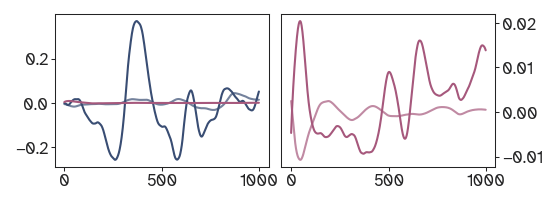

In [16]:
fig, axes = plt.subplot_mosaic([["A", "B"]], figsize=(9 * CM, 3 * CM), dpi=150)
# influence of [this, :, over this]

# 0: lateralorbitofrontal
# 2: lateralorbitofrontal
# 6: medialorbitofrontal
# 20: superiorfrontal

# 9: pars triangularis
# 44: postcentral
axes["A"].plot(hopf_modes[0, :1000, 2], color=NIGHT_BLUE)
axes["A"].plot(hopf_modes[0, :1000, 6], color=NIGHT_BLUE, alpha=0.7)
axes["A"].plot(hopf_modes[0, :1000, 20], color=PURPLE)

axes["B"].plot(hopf_modes[0, :1000, 9], color=PURPLE)
axes["B"].plot(hopf_modes[0, :1000, 44], color=PURPLE, alpha=0.7)
axes["B"].tick_params(
    axis="y", labelright=True, labelleft=False, right=True, left=False
)

fig.tight_layout(pad=0.1)

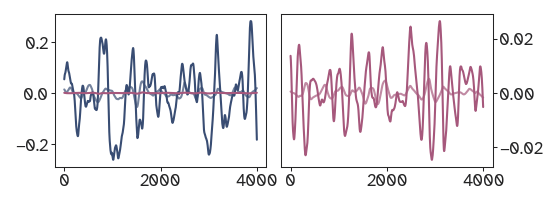

In [17]:
fig, axes = plt.subplot_mosaic([["A", "B"]], figsize=(9 * CM, 3 * CM), dpi=150)

axes["A"].plot(no_transition_hopf_modes[0, :, 2], color=NIGHT_BLUE)
axes["A"].plot(no_transition_hopf_modes[0, :, 6], color=NIGHT_BLUE, alpha=0.7)
axes["A"].plot(no_transition_hopf_modes[0, :, 20], color=PURPLE)

axes["B"].plot(no_transition_hopf_modes[0, :, 9], color=PURPLE)
axes["B"].plot(no_transition_hopf_modes[0, :, 44], color=PURPLE, alpha=0.7)
axes["B"].tick_params(
    axis="y", labelright=True, labelleft=False, right=True, left=False
)

fig.tight_layout(pad=0.1)
plt.savefig(f"figures/HOPF_example_modes.pdf", dpi=600, bbox_inches="tight")

In [18]:
direct_influence = pd.DataFrame(lognorm_l_ci).where(connectivity != 0).fillna(0)
indirect_influence = pd.DataFrame(lognorm_l_ci).where(connectivity == 0).fillna(0)

direct_indirect_hue = indirect_influence.where(
    indirect_influence == 0, -1
) + direct_influence.where(direct_influence == 0, 1)

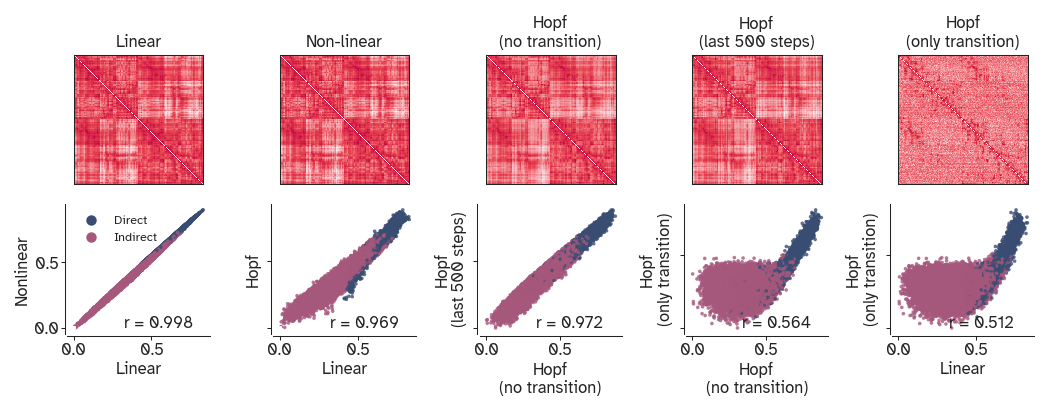

In [19]:
fig, axes = plt.subplot_mosaic(
    [["A", "B", "C", "D", "E"], ["F", "G", "H", "I", "J"]], figsize=HALF_PAGE, dpi=150
)

sns.heatmap(
    lognorm_l_ci,
    square=True,
    xticklabels=False,
    yticklabels=False,
    cmap=white_red_mono,
    cbar=False,
    linewidths=0,
    linecolor=HALF_BLACK,
    rasterized=True,
    ax=axes["A"],
)
axes["A"].set_title("Linear")


sns.heatmap(
    lognorm_nl_ci,
    square=True,
    xticklabels=False,
    yticklabels=False,
    cmap=white_red_mono,
    cbar=False,
    linewidths=0,
    linecolor=HALF_BLACK,
    rasterized=True,
    ax=axes["B"],
)
axes["B"].set_title("Non-linear")


sns.heatmap(
    lognorm_hopf_ci,
    square=True,
    xticklabels=False,
    yticklabels=False,
    cmap=white_red_mono,
    cbar=False,
    linewidths=0,
    linecolor=HALF_BLACK,
    rasterized=True,
    ax=axes["C"],
)
axes["C"].set_title("Hopf\n(no transition)")

sns.heatmap(
    lognorm_short_hopf_ci,
    square=True,
    xticklabels=False,
    yticklabels=False,
    cmap=white_red_mono,
    cbar=False,
    linewidths=0,
    linecolor=HALF_BLACK,
    rasterized=True,
    ax=axes["D"],
)
axes["D"].set_title("Hopf\n(last 500 steps)")

sns.heatmap(
    lognorm_transition_hopf_ci,
    square=True,
    xticklabels=False,
    yticklabels=False,
    cmap=white_red_mono,
    cbar=False,
    linewidths=0,
    linecolor=HALF_BLACK,
    rasterized=True,
    ax=axes["E"],
)
axes["E"].set_title("Hopf\n(only transition)")


sns.scatterplot(
    y=lognorm_nl_ci.flatten(),
    x=lognorm_l_ci.flatten(),
    s=3,
    linewidth=0,
    alpha=0.8,
    hue=direct_indirect_hue.values.flatten(),
    palette=purples_diverge_from_white,
    rasterized=True,
    ax=axes["F"],
)

r = pearsonr(lognorm_nl_ci.flatten(), lognorm_l_ci.flatten())[0]

axes["F"].annotate(
    f"r = {round(r,3)}",
    color=HALF_BLACK,
    xy=(0.4, 0.05),
    xycoords="axes fraction",
)
axes["F"].set_xlabel("Linear")
axes["F"].set_ylabel("Nonlinear")


sns.scatterplot(
    y=lognorm_hopf_ci.flatten(),
    x=lognorm_l_ci.flatten(),
    s=3,
    linewidth=0,
    alpha=0.8,
    hue=direct_indirect_hue.values.flatten(),
    palette=purples_diverge_from_white,
    rasterized=True,
    ax=axes["G"],
)

r = pearsonr(lognorm_hopf_ci.flatten(), lognorm_l_ci.flatten())[0]

axes["G"].annotate(
    f"r = {round(r,3)}",
    color=HALF_BLACK,
    xy=(0.4, 0.05),
    xycoords="axes fraction",
)
axes["G"].set_xlabel("Linear")
axes["G"].set_ylabel("Hopf")


sns.scatterplot(
    y=lognorm_short_hopf_ci.flatten(),
    x=lognorm_hopf_ci.flatten(),
    s=3,
    linewidth=0,
    alpha=0.8,
    hue=direct_indirect_hue.values.flatten(),
    palette=purples_diverge_from_white,
    rasterized=True,
    ax=axes["H"],
)

r = pearsonr(lognorm_hopf_ci.flatten(), lognorm_short_hopf_ci.flatten())[0]

axes["H"].annotate(
    f"r = {round(r,3)}",
    color=HALF_BLACK,
    xy=(0.4, 0.05),
    xycoords="axes fraction",
)
axes["H"].set_xlabel("Hopf\n(no transition)")
axes["H"].set_ylabel("Hopf\n(last 500 steps)")


sns.scatterplot(
    y=lognorm_transition_hopf_ci.flatten(),
    x=lognorm_hopf_ci.flatten(),
    s=3,
    linewidth=0,
    alpha=0.8,
    hue=direct_indirect_hue.values.flatten(),
    palette=purples_diverge_from_white,
    rasterized=True,
    ax=axes["I"],
)

r = pearsonr(lognorm_hopf_ci.flatten(), lognorm_transition_hopf_ci.flatten())[0]

axes["I"].annotate(
    f"r = {round(r,3)}",
    color=HALF_BLACK,
    xy=(0.4, 0.05),
    xycoords="axes fraction",
)
axes["I"].set_xlabel("Hopf\n(no transition)")
axes["I"].set_ylabel("Hopf\n(only transition)")

sns.scatterplot(
    y=lognorm_transition_hopf_ci.flatten(),
    x=lognorm_l_ci.flatten(),
    s=3,
    linewidth=0,
    alpha=0.8,
    hue=direct_indirect_hue.values.flatten(),
    palette=purples_diverge_from_white,
    rasterized=True,
    ax=axes["J"],
)

r = pearsonr(lognorm_l_ci.flatten(), lognorm_transition_hopf_ci.flatten())[0]

axes["J"].annotate(
    f"r = {round(r,3)}",
    color=HALF_BLACK,
    xy=(0.4, 0.05),
    xycoords="axes fraction",
)
axes["J"].set_xlabel("Linear")
axes["J"].set_ylabel("Hopf\n(only transition)")

for axis in [
    "A",
    "B",
    "C",
    "D",
    "E",
]:
    sns.despine(ax=axes[axis], top=False, right=False, left=False, bottom=False)


for axis in [
    "G",
    "H",
    "I",
    "J",
]:
    axes[axis].set_yticklabels([])

for axis in [
    "F",
    "G",
    "H",
    "I",
    "J",
]:
    sns.despine(ax=axes[axis], offset=1, trim=False)

handles = [
    plt.plot(
        [],
        [],
        color=NIGHT_BLUE,
        marker=".",
        linestyle="",
        markersize=8,
        label="Direct",
    )[0],
    plt.plot(
        [], [], color=PURPLE, marker=".", linestyle="", markersize=8, label="Indirect"
    )[0],
]
axes["F"].legend(handles=handles, loc="upper left", frameon=False, fontsize=6)
for ax in ["G", "H", "I", "J"]:
    axes[ax].legend().remove()
fig.tight_layout(pad=1)
plt.savefig(f"figures/model_comparison.pdf", dpi=600, bbox_inches="tight")

In [20]:
SEED = 2023
rubinoved = bct.null_model_und_sign(connectivity, seed=SEED)

/home/kayson/anaconda3/envs/communicability/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


In [21]:
rubinoved[1]

(0.9764187084550519, 0.9764187084550517, nan, nan)

In [22]:
lognorm_rubinoved = ut.log_minmax_normalize(rubinoved[0])

/home/kayson/ownCloud/communication-and-causation/utils.py:288: RuntimeWarning: divide by zero encountered in log
  return np.nan_to_num(np.log(adjacency_matrix), neginf=0, posinf=0)


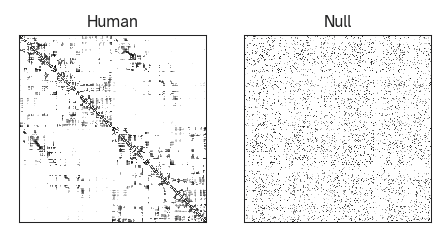

In [23]:
fig, axes = plt.subplot_mosaic([["A", "B"]], figsize=SMALL, dpi=150)


sns.heatmap(
    lognorm_sc,
    cmap="binary",
    square=True,
    xticklabels=False,
    yticklabels=False,
    cbar=False,
    ax=axes["A"],
)

sns.heatmap(
    lognorm_rubinoved,
    cmap="binary",
    square=True,
    xticklabels=False,
    yticklabels=False,
    cbar=False,
    ax=axes["B"],
)
axes["A"].set_title("Human", fontsize=8)
axes["B"].set_title("Null", fontsize=8)

sns.despine(fig=fig, top=False, right=False, left=False, bottom=False)

In [24]:
all_trials = np.zeros((len(connectivity), len(connectivity), N_TRIALS))

for trial in range(N_TRIALS):
    temp = (
        pd.read_pickle(
            f"results/linear_weighted/null_causal_modes_l_w_{len(connectivity)}_{trial}.pickle"
        )
        .groupby(level=0)
        .var()
        .fillna(0)
    )
    all_trials[:, :, trial] = temp
null_averaged_l_ci = all_trials.mean(axis=2)
null_lognorm_l_ci = ut.log_minmax_normalize(null_averaged_l_ci)
null_direct_influence = pd.DataFrame(null_lognorm_l_ci).where(rubinoved[0] != 0)

/home/kayson/ownCloud/communication-and-causation/utils.py:288: RuntimeWarning: divide by zero encountered in log
  return np.nan_to_num(np.log(adjacency_matrix), neginf=0, posinf=0)


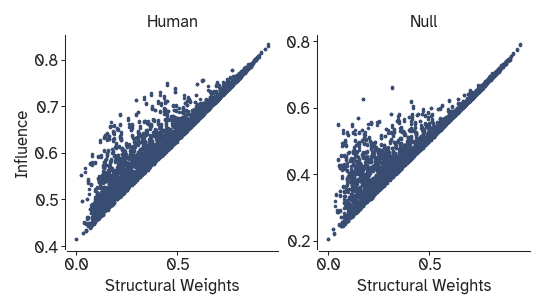

In [25]:
fig, axes = plt.subplot_mosaic([["A", "B"]], figsize=SMALL, dpi=150)

sns.scatterplot(
    x=lognorm_sc.flatten()[connectivity.flatten() != 0],
    y=lognorm_l_ci.flatten()[connectivity.flatten() != 0],
    s=3,
    linewidth=0,
    ax=axes["A"],
    rasterized=True,
    color=NIGHT_BLUE,
)

sns.scatterplot(
    x=lognorm_rubinoved.flatten()[rubinoved[0].flatten() != 0.0],
    y=null_lognorm_l_ci.flatten()[rubinoved[0].flatten() != 0.0],
    s=3,
    linewidth=0,
    ax=axes["B"],
    rasterized=True,
    color=NIGHT_BLUE,
)
axes["A"].set_ylabel("Influence", fontsize=8)
axes["A"].set_xlabel("Structural Weights", fontsize=8)

# axes["B"].set_yticklabels([])
axes["B"].set_xlabel("Structural Weights", fontsize=8)

axes["A"].set_title("Human", fontsize=8)
axes["B"].set_title("Null", fontsize=8)
sns.despine(fig=fig, offset=1, trim=False)
fig.tight_layout(pad=0.5)
plt.savefig(f"figures/sc_ci_null.pdf", dpi=600, bbox_inches="tight")

In [26]:
import networkx as nx

graph_distance = -np.log10(connectivity.copy(order="C"))
nullgraph_distance = -np.log10(rubinoved[0].copy(order="C"))

G_distanced = nx.from_numpy_array(graph_distance)
edge_sp_centrality = nx.edge_betweenness_centrality(
    G_distanced, weight="weight", seed=SEED
)

G_distanced_null = nx.from_numpy_array(nullgraph_distance)
null_edge_sp_centrality = nx.edge_betweenness_centrality(
    G_distanced_null, weight="weight", seed=SEED
)

edge_sp_centrality_matrix = np.zeros_like(connectivity)
for idx, val in edge_sp_centrality.items():
    edge_sp_centrality_matrix[idx[0], idx[1]] = val
    edge_sp_centrality_matrix[idx[1], idx[0]] = val
lognorm_edge_sp_centrality_matrix = ut.log_minmax_normalize(edge_sp_centrality_matrix)

null_edge_sp_centrality_matrix = np.zeros_like(connectivity)
for idx, val in null_edge_sp_centrality.items():
    null_edge_sp_centrality_matrix[idx[0], idx[1]] = val
    null_edge_sp_centrality_matrix[idx[1], idx[0]] = val

null_lognorm_sp_edge_centrality_matrix = ut.log_minmax_normalize(
    null_edge_sp_centrality_matrix
)

/tmp/ipykernel_4323/514731982.py:3: RuntimeWarning: divide by zero encountered in log10
  graph_distance = -np.log10(connectivity.copy(order="C"))
/tmp/ipykernel_4323/514731982.py:4: RuntimeWarning: divide by zero encountered in log10
  nullgraph_distance = -np.log10(rubinoved[0].copy(order="C"))
/home/kayson/ownCloud/communication-and-causation/utils.py:288: RuntimeWarning: divide by zero encountered in log
  return np.nan_to_num(np.log(adjacency_matrix), neginf=0, posinf=0)


In [27]:
G_weighted = nx.from_numpy_array(connectivity)
edge_centrality = nx.edge_current_flow_betweenness_centrality(
    G_weighted, weight="weight"
)

G_weighted_null = nx.from_numpy_array(rubinoved[0])
null_edge_centrality = nx.edge_current_flow_betweenness_centrality(
    G_weighted_null, weight="weight"
)

In [28]:
G_weighted = nx.from_numpy_array(connectivity)
edge_centrality = nx.edge_current_flow_betweenness_centrality(
    G_weighted, weight="weight"
)

G_weighted_null = nx.from_numpy_array(rubinoved[0])
null_edge_centrality = nx.edge_current_flow_betweenness_centrality(
    G_weighted_null, weight="weight"
)

edge_rw_centrality_matrix = np.zeros_like(connectivity)
for idx, val in edge_centrality.items():
    edge_rw_centrality_matrix[idx[0], idx[1]] = val
    edge_rw_centrality_matrix[idx[1], idx[0]] = val
lognorm_edge_rw_centrality_matrix = ut.log_minmax_normalize(edge_rw_centrality_matrix)

null_edge_rw_centrality_matrix = np.zeros_like(connectivity)
for idx, val in null_edge_centrality.items():
    null_edge_rw_centrality_matrix[idx[0], idx[1]] = val
    null_edge_rw_centrality_matrix[idx[1], idx[0]] = val

null_lognorm_edge_rw_centrality_matrix = ut.log_minmax_normalize(
    null_edge_rw_centrality_matrix
)

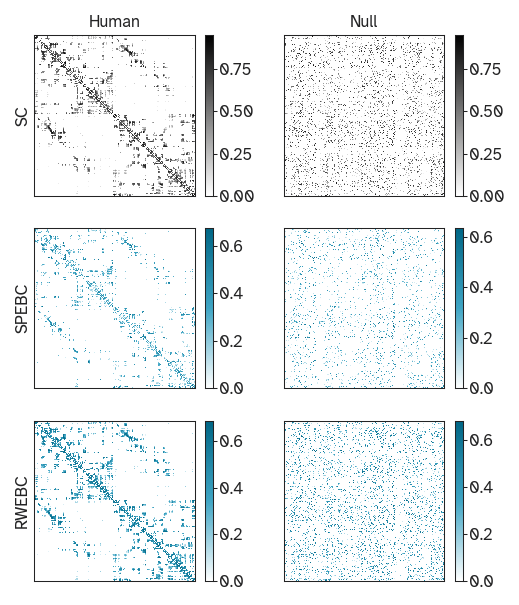

In [29]:
fig, axes = plt.subplot_mosaic(
    [["A", "D"], ["B", "E"], ["C", "F"]], figsize=(10 * CM, 12 * CM), dpi=150
)
sns.heatmap(
    lognorm_sc,
    cmap="binary",
    square=True,
    xticklabels=False,
    yticklabels=False,
    ax=axes["A"],
)
sns.heatmap(
    lognorm_edge_sp_centrality_matrix,
    cmap=white_blue_mono,
    square=True,
    xticklabels=False,
    yticklabels=False,
    ax=axes["B"],
)

sns.heatmap(
    lognorm_rubinoved,
    cmap="binary",
    square=True,
    xticklabels=False,
    yticklabels=False,
    ax=axes["D"],
)
sns.heatmap(
    null_lognorm_sp_edge_centrality_matrix,
    cmap=white_blue_mono,
    square=True,
    xticklabels=False,
    yticklabels=False,
    ax=axes["E"],
)

sns.heatmap(
    lognorm_edge_rw_centrality_matrix,
    cmap=white_blue_mono,
    square=True,
    xticklabels=False,
    yticklabels=False,
    ax=axes["C"],
)
sns.heatmap(
    null_lognorm_edge_rw_centrality_matrix,
    cmap=white_blue_mono,
    square=True,
    xticklabels=False,
    yticklabels=False,
    ax=axes["F"],
)
axes["A"].set_title("Human", fontsize=8)
axes["D"].set_title("Null", fontsize=8)

axes["A"].set_ylabel("SC", fontsize=8)
axes["B"].set_ylabel("SPEBC", fontsize=8)
axes["C"].set_ylabel("RWEBC", fontsize=8)
sns.despine(fig=fig, top=False, right=False, left=False, bottom=False)

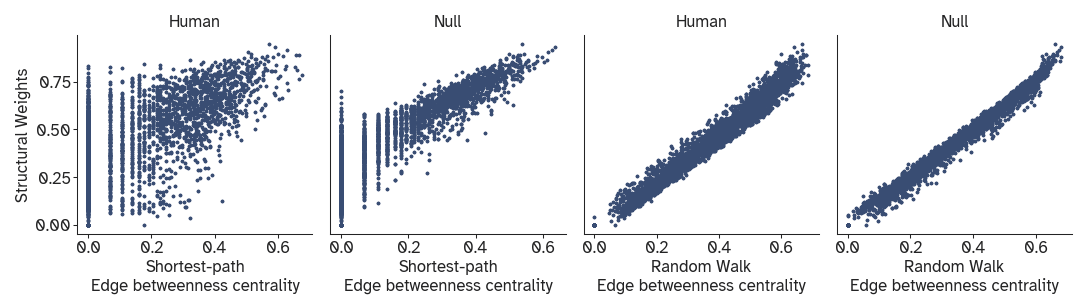

In [30]:
fig, axes = plt.subplot_mosaic(
    [["A", "B", "C", "D"]], figsize=(18 * CM, 5 * CM), dpi=150
)
sns.scatterplot(
    x=lognorm_edge_sp_centrality_matrix.flatten(),
    y=lognorm_sc.flatten(),
    s=3,
    linewidth=0,
    color=NIGHT_BLUE,
    ax=axes["A"],
)
sns.scatterplot(
    x=null_lognorm_sp_edge_centrality_matrix.flatten(),
    y=lognorm_rubinoved.flatten(),
    s=3,
    linewidth=0,
    color=NIGHT_BLUE,
    ax=axes["B"],
)

sns.scatterplot(
    x=lognorm_edge_rw_centrality_matrix.flatten(),
    y=lognorm_sc.flatten(),
    s=3,
    linewidth=0,
    color=NIGHT_BLUE,
    ax=axes["C"],
)
sns.scatterplot(
    x=null_lognorm_edge_rw_centrality_matrix.flatten(),
    y=lognorm_rubinoved.flatten(),
    s=3,
    linewidth=0,
    color=NIGHT_BLUE,
    ax=axes["D"],
)
axes["A"].set_ylabel("Structural Weights", fontsize=8)

axes["A"].set_title("Human", fontsize=8)
axes["B"].set_title("Null", fontsize=8)

axes["C"].set_title("Human", fontsize=8)
axes["D"].set_title("Null", fontsize=8)

for axis in ["B", "C", "D"]:
    axes[axis].set_yticks([])
axes["A"].set_xlabel("Shortest-path\nEdge betweenness centrality", fontsize=8)
axes["B"].set_xlabel("Shortest-path\nEdge betweenness centrality", fontsize=8)

axes["C"].set_xlabel("Random Walk\nEdge betweenness centrality", fontsize=8)
axes["D"].set_xlabel("Random Walk\nEdge betweenness centrality", fontsize=8)

sns.despine(fig=fig, trim=False)
fig.tight_layout(pad=0.5)
plt.savefig(f"figures/SC vs EBC.pdf", dpi=600, bbox_inches="tight")

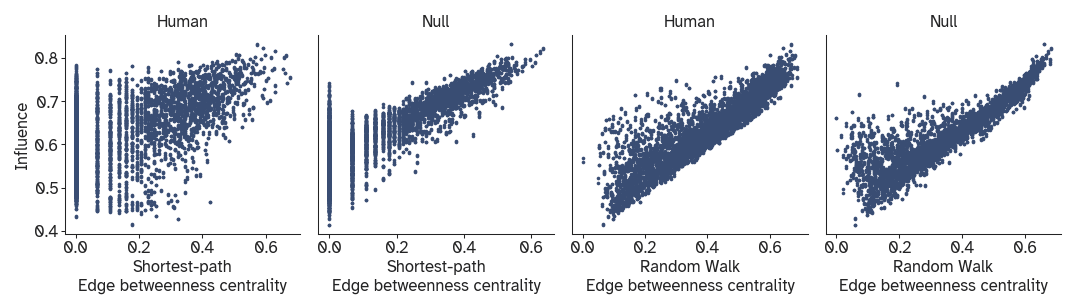

In [31]:
fig, axes = plt.subplot_mosaic(
    [["A", "B", "C", "D"]], figsize=(18 * CM, 5 * CM), dpi=150
)
sns.scatterplot(
    x=lognorm_edge_sp_centrality_matrix.flatten()[connectivity.flatten() != 0],
    y=lognorm_l_ci.flatten()[connectivity.flatten() != 0],
    s=3,
    linewidth=0,
    color=NIGHT_BLUE,
    ax=axes["A"],
)
sns.scatterplot(
    x=null_lognorm_sp_edge_centrality_matrix.flatten()[rubinoved[0].flatten() != 0],
    y=null_lognorm_l_ci.flatten()[rubinoved[0].flatten() != 0],
    s=3,
    linewidth=0,
    color=NIGHT_BLUE,
    ax=axes["B"],
)

sns.scatterplot(
    x=lognorm_edge_rw_centrality_matrix.flatten()[connectivity.flatten() != 0],
    y=lognorm_l_ci.flatten()[connectivity.flatten() != 0],
    s=3,
    linewidth=0,
    color=NIGHT_BLUE,
    ax=axes["C"],
)
sns.scatterplot(
    x=null_lognorm_edge_rw_centrality_matrix.flatten()[rubinoved[0].flatten() != 0],
    y=null_lognorm_l_ci.flatten()[rubinoved[0].flatten() != 0],
    s=3,
    linewidth=0,
    color=NIGHT_BLUE,
    ax=axes["D"],
)
axes["A"].set_ylabel("Influence", fontsize=8)

axes["A"].set_title("Human", fontsize=8)
axes["B"].set_title("Null", fontsize=8)

axes["C"].set_title("Human", fontsize=8)
axes["D"].set_title("Null", fontsize=8)

for axis in ["B", "C", "D"]:
    axes[axis].set_yticks([])
axes["A"].set_xlabel("Shortest-path\nEdge betweenness centrality", fontsize=8)
axes["B"].set_xlabel("Shortest-path\nEdge betweenness centrality", fontsize=8)

axes["C"].set_xlabel("Random Walk\nEdge betweenness centrality", fontsize=8)
axes["D"].set_xlabel("Random Walk\nEdge betweenness centrality", fontsize=8)

sns.despine(fig=fig, trim=False)
fig.tight_layout(pad=0.5)
plt.savefig(f"figures/CI vs EBC.pdf", dpi=600, bbox_inches="tight")

In [32]:
sar_ci = ut.sar_model(connectivity, 0.43)
lognorm_sar_ci = ut.log_minmax_normalize(sar_ci)

In [33]:
from netneurotools.metrics import communicability_wei

communicability = communicability_wei(connectivity)
lognorm_comm = ut.log_minmax_normalize(communicability)

/home/kayson/ownCloud/communication-and-causation/utils.py:288: RuntimeWarning: divide by zero encountered in log
  return np.nan_to_num(np.log(adjacency_matrix), neginf=0, posinf=0)


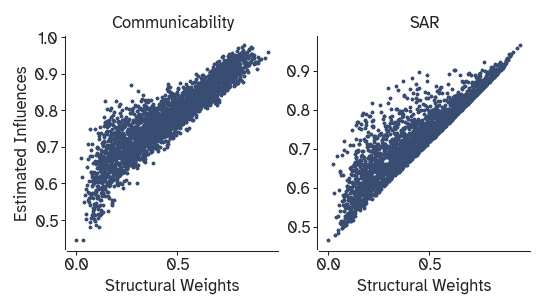

In [34]:
fig, axes = plt.subplot_mosaic([["A", "B"]], figsize=SMALL, dpi=150)

sns.scatterplot(
    x=lognorm_sc.flatten()[connectivity.flatten() != 0],
    y=lognorm_comm.flatten()[connectivity.flatten() != 0.0],
    s=3,
    linewidth=0,
    ax=axes["A"],
    rasterized=True,
    color=NIGHT_BLUE,
)

sns.scatterplot(
    x=lognorm_sc.flatten()[connectivity.flatten() != 0],
    y=lognorm_sar_ci.flatten()[connectivity.flatten() != 0.0],
    s=3,
    linewidth=0,
    ax=axes["B"],
    rasterized=True,
    color=NIGHT_BLUE,
)
axes["A"].set_ylabel("Estimated Influences", fontsize=8)
axes["A"].set_xlabel("Structural Weights", fontsize=8)

# axes["B"].set_yticklabels([])
axes["B"].set_xlabel("Structural Weights", fontsize=8)

axes["A"].set_title("Communicability", fontsize=8)
axes["B"].set_title("SAR", fontsize=8)
sns.despine(fig=fig, offset=1, trim=False)
fig.tight_layout(pad=0.5)
plt.savefig(f"figures/scatter_comm_sar_sc.pdf", dpi=600, bbox_inches="tight")

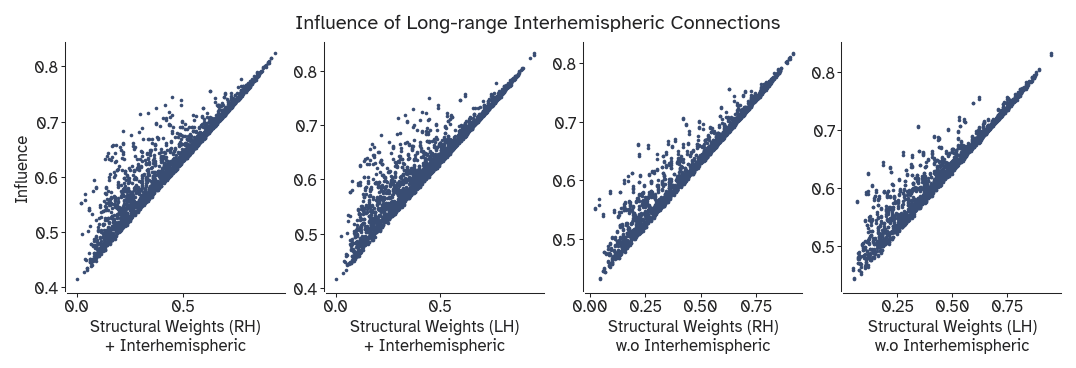

In [35]:
fig, axes = plt.subplot_mosaic(
    [["A", "B", "C", "D"]], figsize=(18 * CM, 6 * CM), dpi=150
)

sns.scatterplot(
    x=lognorm_sc[:107].flatten()[connectivity[:107].flatten() != 0],
    y=lognorm_l_ci[:107].flatten()[connectivity[:107].flatten() != 0],
    s=3,
    linewidth=0,
    ax=axes["A"],
    rasterized=True,
    color=NIGHT_BLUE,
)

sns.scatterplot(
    x=lognorm_sc[108:].flatten()[connectivity[108:].flatten() != 0],
    y=lognorm_l_ci[108:].flatten()[connectivity[108:].flatten() != 0],
    s=3,
    linewidth=0,
    ax=axes["B"],
    rasterized=True,
    color=NIGHT_BLUE,
)
axes["A"].set_ylabel("Influence", fontsize=8)
axes["A"].set_xlabel(
    "Structural Weights (RH)\n+ Interhemispheric", fontsize=8
)

axes["B"].set_xlabel(
    "Structural Weights (LH)\n+ Interhemispheric", fontsize=8
)


sns.scatterplot(
    x=lognorm_sc[:107, :107].flatten()[connectivity[:107, :107].flatten() != 0],
    y=lognorm_l_ci[:107, :107].flatten()[connectivity[:107, :107].flatten() != 0],
    s=3,
    linewidth=0,
    ax=axes["C"],
    rasterized=True,
    color=NIGHT_BLUE,
)

sns.scatterplot(
    x=lognorm_sc[108:, 108:].flatten()[connectivity[108:, 108:].flatten() != 0],
    y=lognorm_l_ci[108:, 108:].flatten()[connectivity[108:, 108:].flatten() != 0],
    s=3,
    linewidth=0,
    ax=axes["D"],
    rasterized=True,
    color=NIGHT_BLUE,
)
axes["C"].set_xlabel(
    "Structural Weights (RH)\nw.o Interhemispheric", fontsize=8
)

# axes["B"].set_yticklabels([])
axes["D"].set_xlabel(
    "Structural Weights (LH)\nw.o Interhemispheric", fontsize=8
)

fig.suptitle("Influence of Long-range Interhemispheric Connections")
sns.despine(fig=fig, offset=1, trim=False)
fig.tight_layout(pad=0.5)

In [36]:
all_trials = np.zeros((len(connectivity), len(connectivity), N_TRIALS))

for trial in range(N_TRIALS):
    temp = (
        pd.read_pickle(
            f"results/linear_weighted/HumanSC_misfitted_causal_modes_l_w_{len(connectivity)}_{trial}.pickle"
        )
        .groupby(level=0)
        .var()
        .fillna(0)
    )
    all_trials[:, :, trial] = temp
misfit_averaged_l_ci = all_trials.mean(axis=2)
misfit_lognorm_l_ci = ut.log_minmax_normalize(misfit_averaged_l_ci)
misfit_direct_influence = pd.DataFrame(misfit_lognorm_l_ci).where(connectivity != 0)

/home/kayson/ownCloud/communication-and-causation/utils.py:288: RuntimeWarning: divide by zero encountered in log
  return np.nan_to_num(np.log(adjacency_matrix), neginf=0, posinf=0)


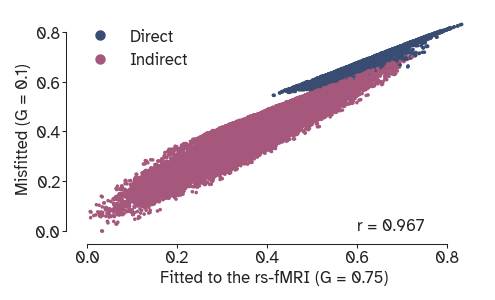

In [37]:
plt.figure(figsize=SMALL, dpi=150)
sns.scatterplot(
    x=lognorm_l_ci.flatten(),
    y=misfit_lognorm_l_ci.flatten(),
    hue=direct_indirect_hue.values.flatten(),
    palette=purples_diverge_from_white,
    s=3,
    linewidth=0,
    rasterized=True,
)
plt.xlabel("Fitted to the rs-fMRI (G = 0.75)", fontsize=8)
plt.ylabel("Misfitted (G = 0.1)", fontsize=8)
sns.despine(trim=True, offset=1)

r = pearsonr(lognorm_l_ci.flatten(), misfit_lognorm_l_ci.flatten())[0]

plt.annotate(
    f"r = {round(r,3)}",
    color=HALF_BLACK,
    xy=(0.7, 0.05),
    xycoords="axes fraction",
)
plt.legend(handles=handles, loc="upper left", frameon=False, fontsize=8)
plt.savefig(f"figures/Fit vs misfit.pdf", dpi=600, bbox_inches="tight")

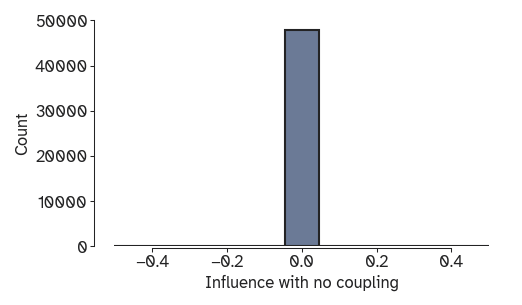

In [38]:
all_trials = np.zeros((len(connectivity), len(connectivity), N_TRIALS))

for trial in range(N_TRIALS):
    temp = (
        pd.read_pickle(
            f"results/linear_weighted/no_coupling_HumanSC_causal_modes_l_w_{len(connectivity)}_{trial}.pickle"
        )
        .groupby(level=0)
        .var()
        .fillna(0)
    )
    all_trials[:, :, trial] = temp
no_coupling_averaged_l_ci = all_trials.mean(axis=2)

plt.figure(figsize=SMALL, dpi=150)
sns.histplot(no_coupling_averaged_l_ci.flatten(), bins=11, color=NIGHT_BLUE)
plt.xlabel("Influence with no coupling", fontsize=8)
sns.despine(trim=True, offset=1)
plt.savefig(f"figures/Uncoupled.pdf", dpi=600, bbox_inches="tight")

/home/kayson/ownCloud/communication-and-causation/utils.py:288: RuntimeWarning: divide by zero encountered in log
  return np.nan_to_num(np.log(adjacency_matrix), neginf=0, posinf=0)


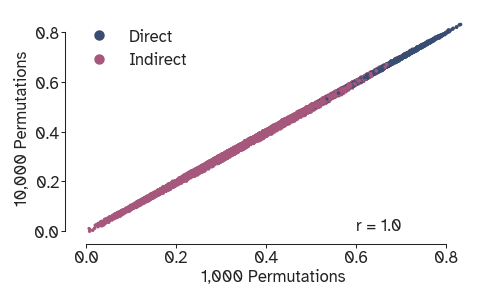

In [39]:
all_trials = np.zeros((len(connectivity), len(connectivity), N_TRIALS))

for trial in range(N_TRIALS):
    temp = (
        pd.read_pickle(
            f"results/linear_weighted/more_perm_HumanSC_causal_modes_l_w_{len(connectivity)}_{trial}.pickle"
        )
        .groupby(level=0)
        .var()
        .fillna(0)
    )
    all_trials[:, :, trial] = temp
more_perm_averaged_l_ci = all_trials.mean(axis=2)
more_perm_lognorm_l_ci = ut.log_minmax_normalize(more_perm_averaged_l_ci)
np.fill_diagonal(more_perm_lognorm_l_ci, 0.0)


plt.figure(figsize=SMALL, dpi=150)
sns.scatterplot(
    x=lognorm_l_ci.flatten(),
    y=more_perm_lognorm_l_ci.flatten(),
    hue=direct_indirect_hue.values.flatten(),
    palette=purples_diverge_from_white,
    s=3,
    linewidth=0,
    rasterized=True,
)
plt.xlabel("1,000 Permutations", fontsize=8)
plt.ylabel("10,000 Permutations", fontsize=8)
sns.despine(trim=True, offset=1)

r = pearsonr(lognorm_l_ci.flatten(), more_perm_lognorm_l_ci.flatten())[0]

plt.annotate(
    f"r = {round(r,3)}",
    color=HALF_BLACK,
    xy=(0.7, 0.05),
    xycoords="axes fraction",
)
plt.legend(handles=handles, loc="upper left", frameon=False, fontsize=8)
plt.savefig(f"figures/larger_samples.pdf", dpi=600, bbox_inches="tight")

In [40]:
from itertools import product

In [41]:
rng = np.random.default_rng(seed=SEED)
binary_connectivity = np.where(connectivity != 0, 1, 0)
shuffled_connectomes = np.zeros((len(connectivity),len(connectivity),10))
for trial in range(N_TRIALS):
    weights = connectivity.flatten()[connectivity.flatten() != 0].copy()
    rng.shuffle(weights)
    ix = 0
    temp = binary_connectivity.copy().astype(float)
    for i,j in product(range(len(connectivity)), range(len(connectivity))):
        if binary_connectivity[i,j] == 1:
            shuffled_connectomes[i,j,trial] = weights[ix]
            ix += 1


In [42]:
ws_trials = np.zeros((len(connectivity), len(connectivity), N_TRIALS))

for trial in range(N_TRIALS):
    temp = (
        pd.read_pickle(
            f"results/linear_weighted/weight_shuffle_causal_modes_l_w_{len(connectivity)}_{trial}.pickle"
        )
        .groupby(level=0)
        .var()
        .fillna(0)
    )
    ws_trials[:, :, trial] = temp

lognorm_shuffled_sc = np.zeros_like(shuffled_connectomes)


weight_shuffle_lognorm_l_ci = np.zeros_like(ws_trials)
weight_shuffle_direct_influence = np.zeros_like(ws_trials)
for trial in range(N_TRIALS):
    weight_shuffle_lognorm_l_ci[:,:,trial] = ut.log_minmax_normalize(ws_trials[:, :, trial])
    weight_shuffle_direct_influence[:,:,trial] = pd.DataFrame(weight_shuffle_lognorm_l_ci[:, :, trial]).where(connectivity != 0)
    lognorm_shuffled_sc[:,:,trial] = ut.log_minmax_normalize(shuffled_connectomes[:,:,trial])

/home/kayson/ownCloud/communication-and-causation/utils.py:288: RuntimeWarning: divide by zero encountered in log
  return np.nan_to_num(np.log(adjacency_matrix), neginf=0, posinf=0)
/home/kayson/ownCloud/communication-and-causation/utils.py:288: RuntimeWarning: divide by zero encountered in log
  return np.nan_to_num(np.log(adjacency_matrix), neginf=0, posinf=0)
/home/kayson/ownCloud/communication-and-causation/utils.py:288: RuntimeWarning: divide by zero encountered in log
  return np.nan_to_num(np.log(adjacency_matrix), neginf=0, posinf=0)
/home/kayson/ownCloud/communication-and-causation/utils.py:288: RuntimeWarning: divide by zero encountered in log
  return np.nan_to_num(np.log(adjacency_matrix), neginf=0, posinf=0)
/home/kayson/ownCloud/communication-and-causation/utils.py:288: RuntimeWarning: divide by zero encountered in log
  return np.nan_to_num(np.log(adjacency_matrix), neginf=0, posinf=0)
/home/kayson/ownCloud/communication-and-causation/utils.py:288: RuntimeWarning: divid

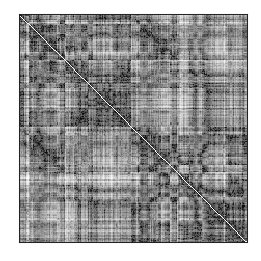

In [43]:
plt.figure(figsize=SMALL, dpi=150)
sns.heatmap(weight_shuffle_lognorm_l_ci[:,:,4], cmap="Greys", square=True, cbar=False, xticklabels=False, yticklabels=False,)
sns.despine(left=False, bottom=False, right=False, top=False)

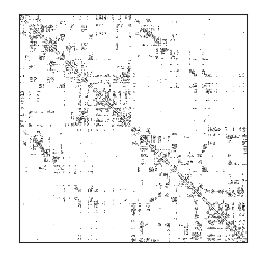

In [44]:
plt.figure(figsize=SMALL, dpi=150)

sns.heatmap(lognorm_shuffled_sc[:,:,4], cmap="Greys", square=True, cbar=False, xticklabels=False, yticklabels=False,)
sns.despine(left=False, bottom=False, right=False, top=False)

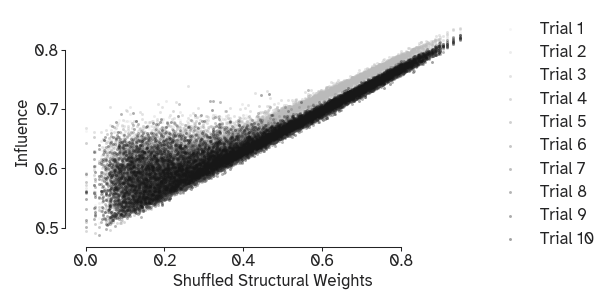

In [45]:
plt.figure(figsize=SMALL, dpi=150)
with sns.color_palette('gray_r', n_colors=N_TRIALS):
    for i in range(N_TRIALS):
        sns.scatterplot(
            x=lognorm_shuffled_sc[:,:,i].flatten()[connectivity.flatten() != 0],
            y=weight_shuffle_lognorm_l_ci[:,:,i].flatten()[connectivity.flatten() != 0],
            s=2,
            linewidth=0,
            rasterized=True,
            alpha=0.4,
            label=f"Trial {i+1}"
        )

plt.ylabel("Influence", fontsize=8)
plt.xlabel("Shuffled Structural Weights", fontsize=8)

plt.legend( frameon=False, fontsize=8,bbox_to_anchor=(1, 1.05))

sns.despine( offset=1, trim=True)
fig.tight_layout(pad=0.5)
plt.savefig(f"figures/scatter_sc_ci_weight_shuffle.pdf", dpi=600, bbox_inches="tight")

In [46]:
degree_centrality = binary_connectivity.sum(axis=0)/binary_connectivity.shape[0]

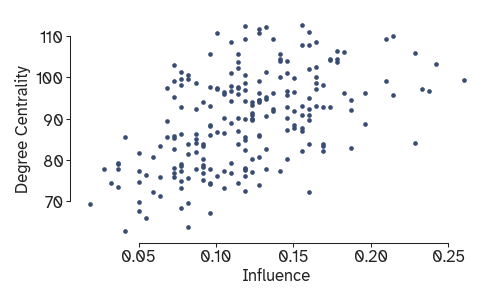

In [47]:
plt.figure(figsize=SMALL, dpi=150)

sns.scatterplot(
    y=lognorm_l_ci.sum(axis=0).flatten(),
    x=degree_centrality.flatten(),
    s=5,
    linewidth=0,
    rasterized=True,
    color=NIGHT_BLUE,
)

plt.ylabel("Degree Centrality", fontsize=8)
plt.xlabel("Influence", fontsize=8)

sns.despine( offset=0.5, trim=True)
fig.tight_layout(pad=0.5)